In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from datetime import datetime
np.random.seed(42)

## Path for Dataset

In [2]:
data_dir = '../input/german-traffic-sign/German Traffic Sign Recognition'
train_path = '../input/german-traffic-sign/German Traffic Sign Recognition/train'
test_path = '../input/german-traffic-sign/German Traffic Sign Recognition/test.csv'

# Resizing the images to 32x32x3 or 112x112x3
IMG_H_32 = 32
IMG_W_32 = 32
IMG_H_112 = 112
IMG_W_112 = 112
channels = 3

SIZE = (IMG_H_112, IMG_H_112)

## Total Classes

In [3]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES
CATEGORIES = os.listdir(train_path)

In [4]:
# Label Overview
classes = {
    18:'General caution',
    14:'Stop', 
    25:'Road work',
    17:'No entry',
    26:'Traffic signals',
    33:'Turn right',
    34:'Turn left',
    5:'Speed limit (80km/h)',
    2:'Speed limit (50km/h)',
    3:'Speed limit (60km/h)',
    28:'Children crossing',
    30:'Beware of ice/snow',
    23:'Slippery road',
    4:'Speed limit (70km/h)',
    9:'No passing',    
}

## Visualizing The Dataset

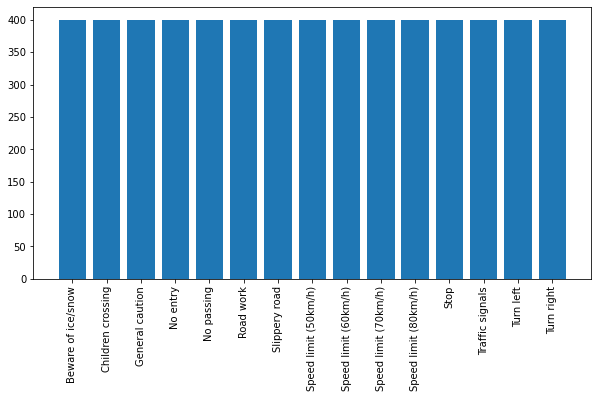

In [5]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(10,5))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

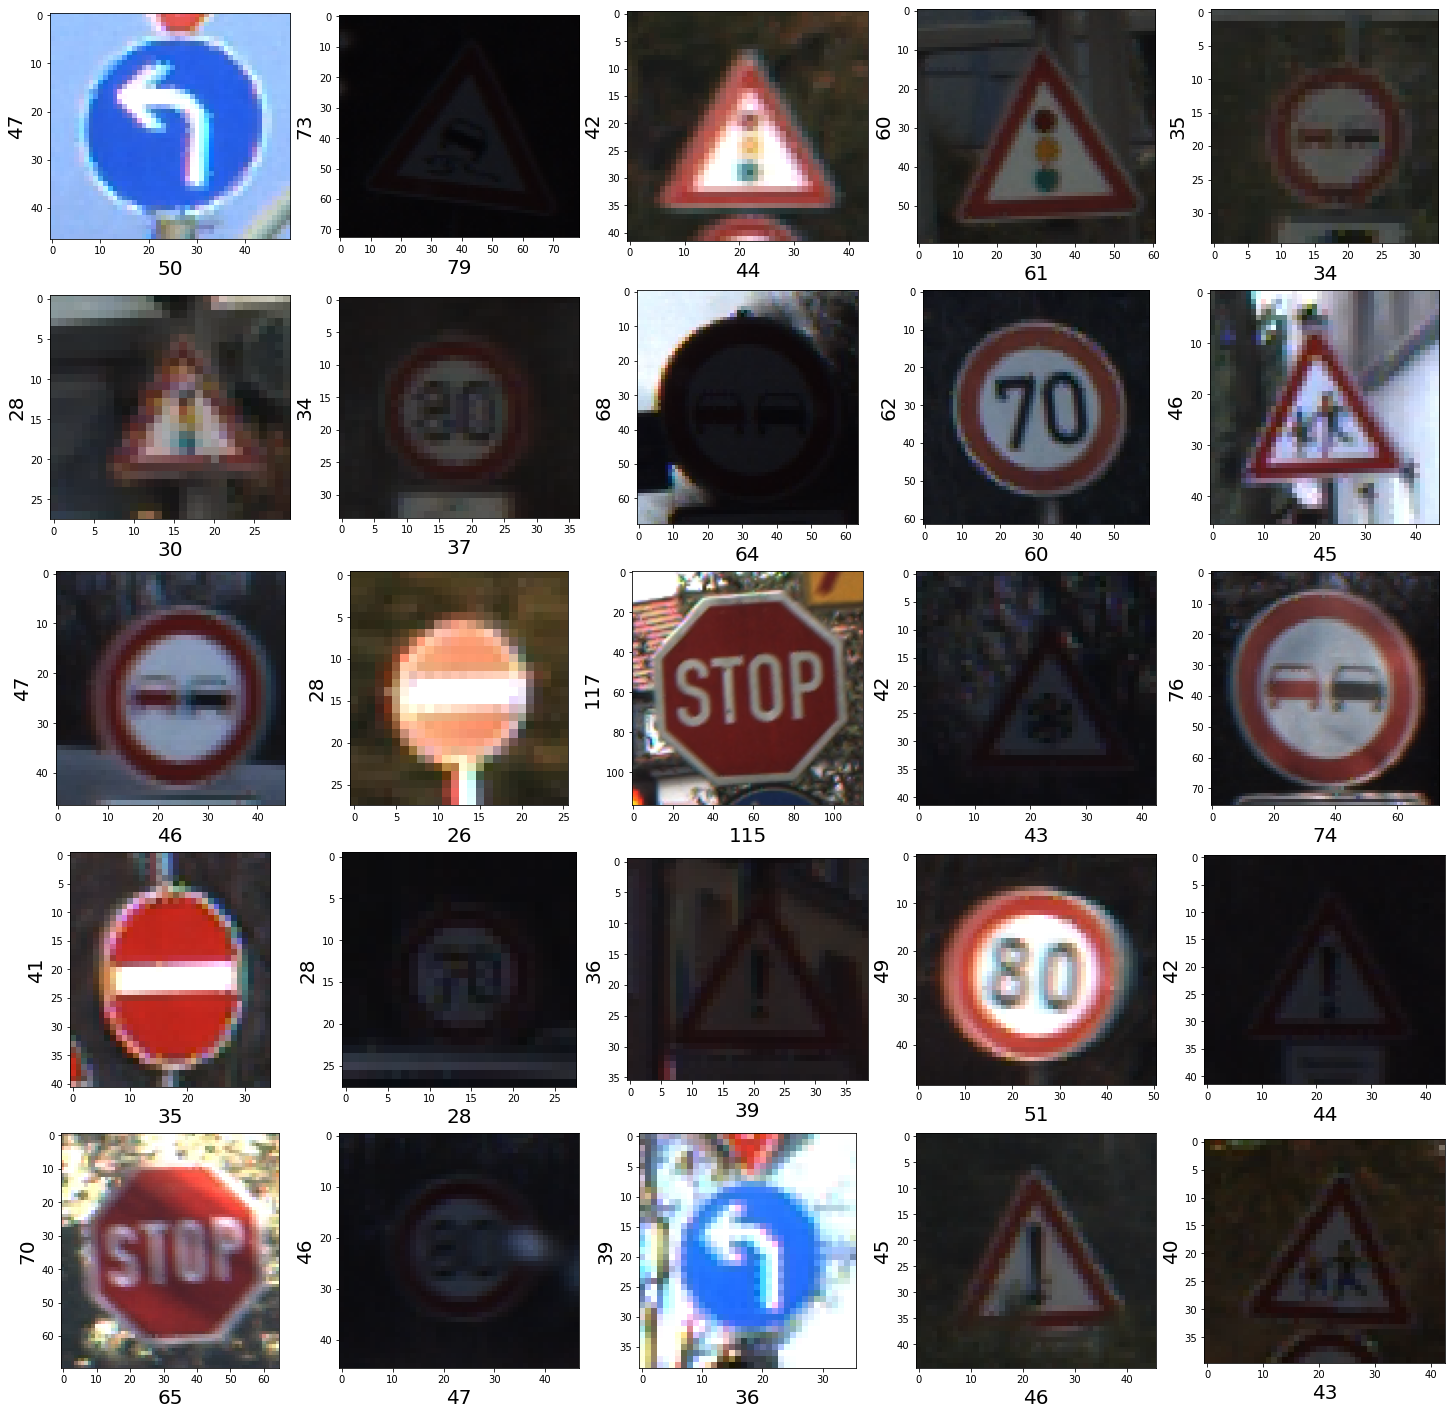

In [6]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/test.csv')
imgs = test["path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(False)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

## Collecting the Training Data

In [7]:
train = pd.read_csv(data_dir + '/train.csv')
train.head()

,Unnamed: 0,path,label
0,0,train/26/183.png,26
1,1,train/3/318.png,3
2,2,train/18/222.png,18
3,3,train/33/136.png,33
4,4,train/4/25.png,4


In [8]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder() 
enc.fit(train['label'].values)
train['label_enc'] = enc.transform(train['label'])
train.head()

,Unnamed: 0,path,label,label_enc
0,0,train/26/183.png,26,10
1,1,train/3/318.png,3,1
2,2,train/18/222.png,18,7
3,3,train/33/136.png,33,13
4,4,train/4/25.png,4,2


In [9]:
image_data = [];
image_labels = [];

min_img = (1000, 1000)
max_img = (0, 0)

for i in range(len(train)):
    row = train.iloc[i]
    img = cv2.imread(data_dir + '/' + row['path'])
    
    min_img = min(min_img, img.shape)
    max_img = max(max_img, img.shape)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resize_img = cv2.resize(img, SIZE)
    image_data.append(resize_img)
    image_labels.append(row['label_enc'])

# list to numpy array 
image_data = np.array(image_data) 
image_labels = np.array(image_labels) 

print(image_data.shape, image_labels.shape)
print('Training image:')
print("The smallest image: ", min_img)
print("The biggest image: ", max_img)

(6000, 112, 112, 3) (6000,)
Training image:
The smallest image:  (25, 25, 3)
The biggest image:  (89, 77, 3)


## Collecting the Testing Data

In [10]:
test = pd.read_csv(data_dir + '/test.csv')
test['label_enc'] = enc.transform(test['label'])
test.head()

,Unnamed: 0,path,label,label_enc
0,0,test/1.png,33,13
1,1,test/2.png,18,7
2,2,test/3.png,25,9
3,3,test/4.png,23,8
4,4,test/5.png,4,2


In [11]:
y_test = test['label_enc'].values
imgs = test['path'].values

X_test = []
min_img = (1000, 1000)
max_img = (0, 0)

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' + img)
        
        min_img = min(min_img, image.shape)
        max_img = max(max_img, image.shape)
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        resized_img = cv2.resize(image, SIZE)
        X_test.append(resized_img)
    except:
        pass; 
X_test = np.array(X_test)
y_test = np.array(y_test)
X_test = X_test/255.0

print(X_test.shape, y_test.shape)
print('\nTesting image:')
print("The smallest image: ", min_img)
print("The biggest image: ", max_img)

(450, 112, 112, 3) (450,)

Testing image:
The smallest image:  (26, 26, 3)
The biggest image:  (163, 168, 3)


## Splitting the data into train and validation set

In [12]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.2, random_state=42, shuffle=True)

X_train = X_train/255.0
X_val = X_val/255.0

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (4800, 112, 112, 3)
X_valid.shape (1200, 112, 112, 3)
y_train.shape (4800,)
y_valid.shape (1200,)


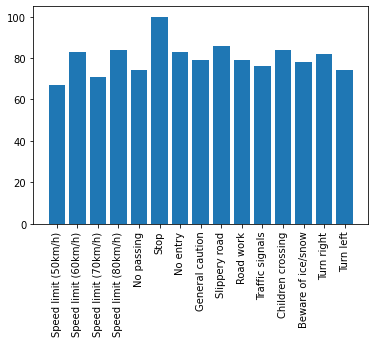

In [13]:
# Visualizing data validation
val_count = [0] * NUM_CATEGORIES

for x in y_val:
    val_count[x] += 1;

plt.bar([classes[x] for x in enc.inverse_transform(np.arange(15))], val_count)
plt.xticks(rotation='vertical')
plt.show()

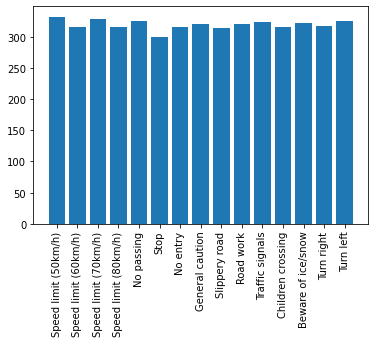

In [14]:
# Visualizing data train
train_count = [0] * NUM_CATEGORIES

for x in y_train:
    train_count[x] += 1;

plt.bar([classes[x] for x in enc.inverse_transform(np.arange(15))], train_count)
plt.xticks(rotation='vertical')
plt.show()

## One hot encoding the labels

In [15]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(4800, 15)
(1200, 15)


## Data Augmentation

In [16]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.3,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

## Define the Model and Training

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 1e-3,
    patience = 10,
    mode = 'min',
)

### 1. VGG16

In [18]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg = VGG16(weights = 'imagenet', include_top = False, input_shape=(IMG_H_112, IMG_W_112, channels))
# vgg.summary()

58892288/58889256 [==============================] - 0s 0us/step


Epoch 1/50
300/300 [==============================] - 20s 67ms/step - loss: 3.2214 - accuracy: 0.0617 - val_loss: 2.9638 - val_accuracy: 0.0783
Epoch 2/50
300/300 [==============================] - 19s 63ms/step - loss: 3.1736 - accuracy: 0.0650 - val_loss: 2.9429 - val_accuracy: 0.0792
Epoch 3/50
300/300 [==============================] - 20s 66ms/step - loss: 3.1583 - accuracy: 0.0554 - val_loss: 2.9231 - val_accuracy: 0.0808
Epoch 4/50
300/300 [==============================] - 20s 65ms/step - loss: 3.1388 - accuracy: 0.0602 - val_loss: 2.9045 - val_accuracy: 0.0808
Epoch 5/50
300/300 [==============================] - 19s 64ms/step - loss: 3.1139 - accuracy: 0.0662 - val_loss: 2.8873 - val_accuracy: 0.0825
Epoch 6/50
300/300 [==============================] - 19s 64ms/step - loss: 3.1140 - accuracy: 0.0637 - val_loss: 2.8709 - val_accuracy: 0.0842
Epoch 7/50
300/300 [==============================] - 19s 64ms/step - loss: 3.0869 - accuracy: 0.0690 - val_loss: 2.8554 - val_accuracy:

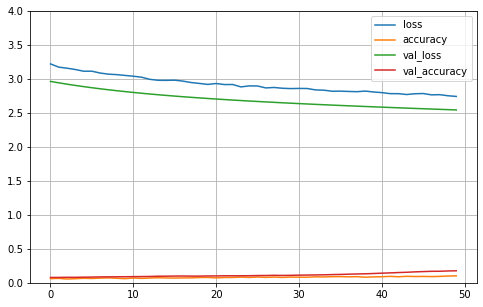

Accuracy of VGG16:  15.333333333333332


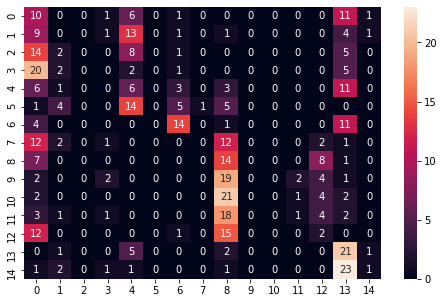

In [19]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg = VGG16(weights = 'imagenet', include_top = False, input_shape=(IMG_H_112, IMG_W_112, channels))
# vgg.summary()

X = vgg.layers[-1].output
X = tf.keras.layers.Flatten()(X)
X = tf.keras.layers.Dense(512, activation='relu')(X)
# X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dropout(0.5)(X)
X = tf.keras.layers.Dense(NUM_CATEGORIES, activation='softmax')(X)

vgg_model = Model(vgg.input, X)

vgg_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-7, momentum=0.9),
    metrics =  ['accuracy']
)

# vgg_model.summary()

vgg_history = vgg_model.fit(
    aug.flow(X_train, y_train, batch_size=16, shuffle=True),
    epochs = 50,
    validation_data = (X_val, y_val),
    callbacks = [early_stopping]
)

pd.DataFrame(vgg_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,4)
plt.show()

y_pred = vgg_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
#Accuracy with the test data
print('Accuracy of VGG16: ',accuracy_score(y_test,y_pred)*100)

cf = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cf)
plt.figure(figsize = (8,5))
sns.heatmap(df_cm, annot=True)

In [20]:
# vgg_history = vgg_model.fit(
#     aug.flow(X_train, y_train, batch_size=32, shuffle=True),
#     epochs = 50,
#     validation_data = (X_val, y_val),
#     callbacks = [early_stopping]
# )

In [21]:
# y_pred = vgg_model.predict(X_test)
# y_pred = np.argmax(y_pred, axis=1)
# #Accuracy with the test data
# print('Accuracy of VGG16: ',accuracy_score(y_test,y_pred)*100)

### 2. InceptionV3

In [22]:
from tensorflow.keras.applications import InceptionV3
inception = InceptionV3(weights='imagenet', include_top = False, input_shape=(IMG_H_112, IMG_W_112, channels))
# inception.summary()

87916544/87910968 [==============================] - 0s 0us/step


Epoch 1/50
150/150 [==============================] - 19s 125ms/step - loss: 3.3142 - accuracy: 0.0702 - val_loss: 2.9877 - val_accuracy: 0.0658
Epoch 2/50
150/150 [==============================] - 17s 115ms/step - loss: 3.3062 - accuracy: 0.0685 - val_loss: 3.0680 - val_accuracy: 0.0608
Epoch 3/50
150/150 [==============================] - 19s 127ms/step - loss: 3.2766 - accuracy: 0.0740 - val_loss: 3.0966 - val_accuracy: 0.0650
Epoch 4/50
150/150 [==============================] - 19s 126ms/step - loss: 3.3147 - accuracy: 0.0731 - val_loss: 3.1002 - val_accuracy: 0.0708
Epoch 5/50
150/150 [==============================] - 17s 115ms/step - loss: 3.3069 - accuracy: 0.0594 - val_loss: 3.0993 - val_accuracy: 0.0725
Epoch 6/50
150/150 [==============================] - 18s 120ms/step - loss: 3.3042 - accuracy: 0.0667 - val_loss: 3.0702 - val_accuracy: 0.0750
Epoch 7/50
150/150 [==============================] - 21s 138ms/step - loss: 3.3072 - accuracy: 0.0660 - val_loss: 3.0835 - val_ac

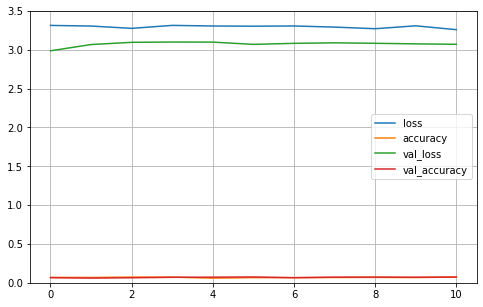

Accuracy of VGG16:  6.666666666666667


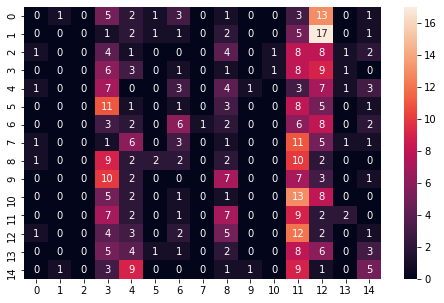

In [23]:
from tensorflow.keras.applications import InceptionV3
inception = InceptionV3(weights='imagenet', include_top = False, input_shape=(IMG_H_112, IMG_W_112, channels))

X = inception.layers[-1].output 
X = tf.keras.layers.Flatten()(X)
X = tf.keras.layers.Dense(512, activation='relu')(X)
X = tf.keras.layers.Dropout(0.5)(X) 
X = tf.keras.layers.Dense(NUM_CATEGORIES, activation='softmax')(X)

# Define the Inception Model
inception_model = Model(inception.input, X)

inception_model.compile(
    loss = 'categorical_crossentropy',
#     optimizer = Adam(learning_rate = 1e-7),
    optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-7, momentum = 0.9),
    metrics = ['accuracy']
)

# inception_model.summary()

inception_history = inception_model.fit(
    aug.flow(X_train, y_train, batch_size=32, shuffle=True),
    epochs = 50,
    validation_data = (X_val, y_val),
    callbacks = [early_stopping]
)

pd.DataFrame(inception_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,3.5)
plt.show()

y_pred = inception_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
#Accuracy with the test data
print('Accuracy of VGG16: ',accuracy_score(y_test,y_pred)*100)

cf = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cf)
plt.figure(figsize = (8,5))
sns.heatmap(df_cm, annot=True)

In [24]:
# inception_history = inception_model.fit(
#     aug.flow(X_train, y_train, batch_size=32, shuffle=True),
#     epochs = 50,
#     validation_data=(X_val, y_val),
#     callbacks = [early_stopping]
# )

In [25]:
# y_pred = inception_model.predict(X_test)
# y_pred = np.argmax(y_pred, axis=1)
# #Accuracy with the test data
# print('Accuracy of InceptionV3: ',accuracy_score(y_test,y_pred)*100)

## Evaluating the model

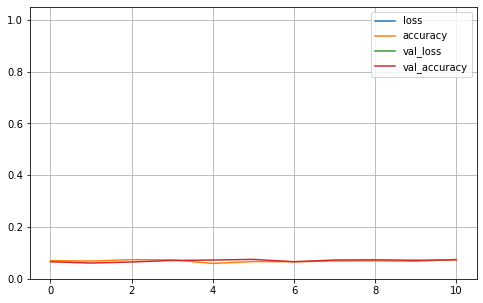

In [26]:
pd.DataFrame(inception_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.05)
plt.show()

## Predictions

In [27]:
y_pred = inception_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(y_test,y_pred)*100)

Test Data accuracy:  6.666666666666667


## Visualizing the confusion matrix

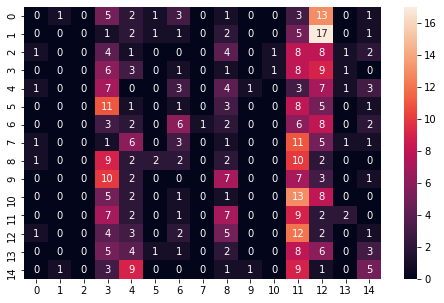

In [28]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_test, y_pred)

import seaborn as sns
df_cm = pd.DataFrame(cf)
plt.figure(figsize = (8,5))
sns.heatmap(df_cm, annot=True)

## Classification report

In [29]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.00      0.00      0.00        30
           2       0.00      0.00      0.00        30
           3       0.07      0.20      0.11        30
           4       0.00      0.00      0.00        30
           5       0.00      0.00      0.00        30
           6       0.24      0.20      0.22        30
           7       0.00      0.00      0.00        30
           8       0.05      0.07      0.05        30
           9       0.00      0.00      0.00        30
          10       0.00      0.00      0.00        30
          11       0.07      0.30      0.12        30
          12       0.02      0.07      0.03        30
          13       0.00      0.00      0.00        30
          14       0.24      0.17      0.20        30

    accuracy                           0.07       450
   macro avg       0.05      0.07      0.05       450
weighted avg       0.05   

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Predictions on Test Data

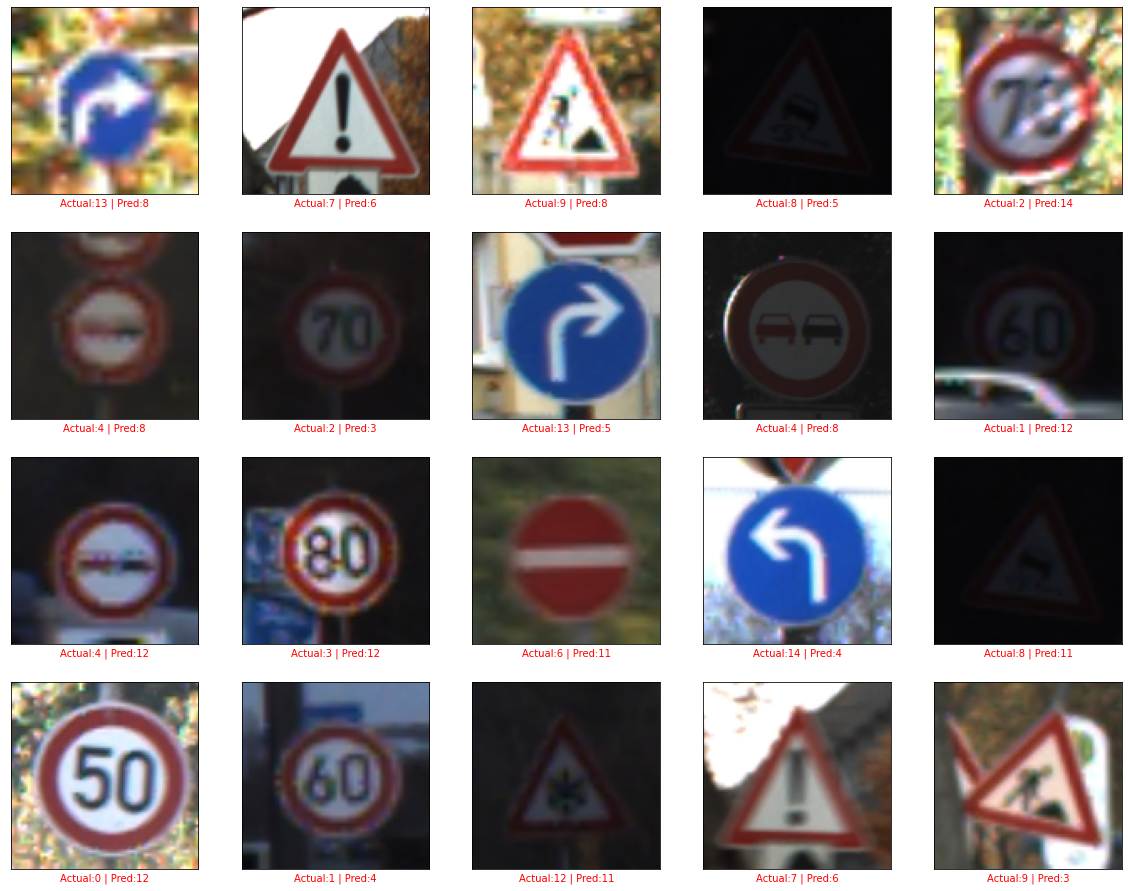

In [30]:
plt.figure(figsize = (20, 20))

index = 1;
for i in range(len(X_test)):
    if(y_test[i] == y_pred[i]):
        continue;
        
    plt.subplot(5,5, index);
    index += 1;
    plt.grid(False);
    plt.xticks([]);
    plt.yticks([]);
    if(y_test[i] != y_pred[i]):
        plt.xlabel(f"Actual:{y_test[i]} | Pred:{y_pred[i]}", color='r')
        plt.imshow(X_test[i])
    if(index > 20):
        break; 
plt.show()